# What's up, MTV? Welcome to my MVP!

In [1]:
# Let's begin by reading in all the necessary libraries, and setting some baseline parameters for pandas and matplotlib.
%reset -f
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('max_columns', 20)
pd.set_option('max_rows', 20)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Let's now read the data in from the SQL database using SQLAlchemy.
# It's possible to do all cleaning and aggregation in SQL, but for now we will use Pandas after a SELECT *
engine = create_engine("sqlite:////Users/nathanieldirenzo/Documents/GitHub/NBM_EDA_Student/resources/get_mta/mta_data.db")

In [3]:
#Create the dataframe
df = pd.read_sql('SELECT * FROM mta_data LIMIT 250000;', engine)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,03:00:00,REGULAR,7672966,2645023
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,07:00:00,REGULAR,7672969,2645040
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,11:00:00,REGULAR,7672991,2645127
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,15:00:00,REGULAR,7673037,2645193
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/18/2021,19:00:00,REGULAR,7673097,2645270


In [4]:
# Clean up column names for easier use
df = df.rename(columns={'C/A': 'control_area', 'UNIT': 'unit', 'SCP': 'subunit_channel_pos', 'STATION':'station', 'LINENAME':'subway_lines', 'DIVISION':'division', 'DATE':'date', 'TIME':'time', 'DESC':'desc', 'ENTRIES':'entries', 'EXITS':'exits'})

In [5]:
df['date'] = df['date'].str.replace('/','_')
df['time'] = df['time'].str.replace(':','_')
df['desc'] = df['desc'].str.replace(' ', '_')
df['subunit_channel_pos'] = df['subunit_channel_pos'].str.replace('-', '_')
df['station'] = df['station'].str.replace('-', '_')
df['station'] = df['station'].str.replace(' ', '_')
df['station'] = df['station'].str.replace('/','_')

In [6]:
# Create a date_time column that is a pandas datetime value-- useful for lots of analysis.
df['date_time'] = df.date + ' ' + df.time

In [7]:
df.date_time = pd.to_datetime(df['date_time'], format = '%m_%d_%Y %H_%M_%S')

In [8]:
#Recovery Audits look like a messy type of audit. We're making an executive decision to ax them.
df = df[df.desc != 'RECOVR_AUD']

In [9]:
# Find the difference between the Entries values for each turnstile in each preceeding row. 
#This is the number of entires for that audit observation. Likewise for exits. Traffic is the total of these two values.
df['net_entries'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['entries'].transform(lambda x: x.diff())
df['net_exits'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['exits'].transform(lambda x: x.diff())
df['net_traffic'] = df.net_entries + df.net_exits

In [10]:
# There are a number of negatives -- these appear to be instances where the counter works in reverse. As a first step to cleaning this up we'll make them positive values.
df['net_entries'] = abs(df.net_entries)
df['net_exits'] = abs(df.net_exits)
df['net_traffic'] = abs(df.net_traffic)

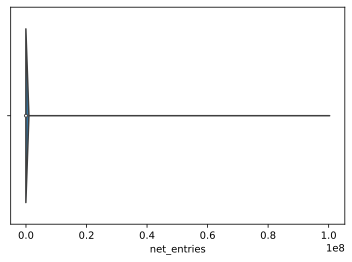

In [11]:
# What does the distribution on these values look like
sns.violinplot(x=df.net_entries);

In [12]:
# Waaaaaay skewed. Let's hack this down to size via percentiles. After some trial and error I landed on 95th percentile as a good number to get rid of the biggest outliers, and normalize the dataset.
q = np.nanquantile(df["net_entries"], .95)
df = df[df["net_entries"] < q]

q2 = np.nanquantile(df["net_exits"], .95)
df = df[df["net_exits"] < q2]

q3 = np.nanquantile(df['net_traffic'], .95)
df=df[df['net_traffic'] < q3]

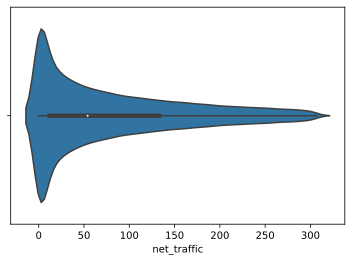

In [13]:
sns.violinplot(data=df, x='net_traffic');

In [14]:
# Create a bunch of columns for use in the final product
df['audit_length_hours'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['date_time'].transform(lambda x: x.diff())

In [15]:
df['audit_length_hours'] = df.audit_length_hours.dt.total_seconds() / 3600

In [16]:
df['day_of_week'] = df.date_time.dt.dayofweek

In [17]:
df['month'] = df.date_time.dt.month

In [18]:
df['week'] = df.date_time.dt.isocalendar().week

In [19]:
df['hour'] = df.date_time.dt.hour

In [20]:
df['pct_change'] = df.groupby(['control_area', 'unit', 'subunit_channel_pos', 'station'])['net_traffic'].transform(lambda x: x.pct_change())
df['pct_change'] = df['pct_change'].astype(float).map("{:.2%}".format)

In [21]:
# Create and plot a number of dataframes based on datetime values.
hourly_df = df.groupby(['hour'])[['net_traffic']].mean().reset_index().copy()

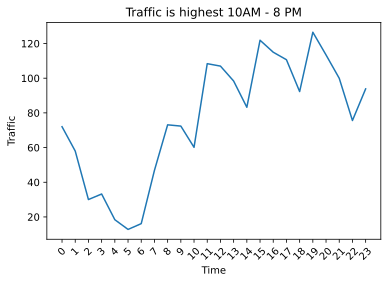

In [22]:
# Average traffic for all tunrstiles in all stations over a 24 hour period
plt.plot(hourly_df.hour, hourly_df.net_traffic);
plt.xlabel('Time')
plt.ylabel('Traffic')
plt.title('Traffic is highest 10AM - 8 PM')
plt.xticks(np.arange(24), rotation=45);
plt.savefig('hourlytraffic.png')

In [23]:
timelapse_df = df.groupby(pd.Grouper(key='date_time', freq='H'))[['net_traffic']].mean().reset_index()
timelapse_df['pct_change'] = hourly_df.net_traffic.pct_change()

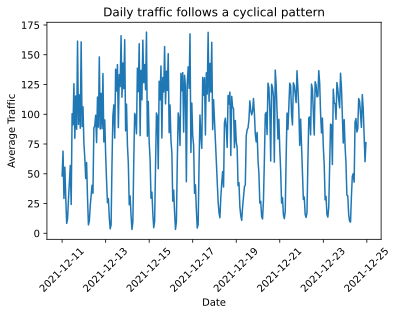

In [24]:
# Timelapse data by hour of the average traffic in the entire subway system
sns.lineplot(data=timelapse_df, x='date_time', y='net_traffic');
plt.title('Daily traffic follows a cyclical pattern')
plt.xlabel('Date')
plt.ylabel('Average Traffic')
plt.xticks(rotation=45);

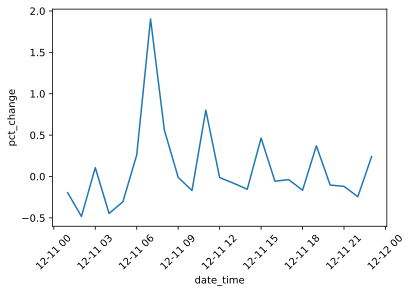

In [25]:
# Timelapse data of the percentage change between hours.
sns.lineplot(data=timelapse_df, x='date_time', y='pct_change');
plt.xticks(rotation=45);

In [26]:
# Aggregate data for the day of the week
daily_df = df.groupby(df.day_of_week)[['net_traffic']].sum()
daily_df['pct_change'] = daily_df.net_traffic.pct_change()
daily_df['pct_change'].iloc[0] = ((daily_df.net_traffic.iloc[0] - daily_df.net_traffic.iloc[6]) / daily_df.net_traffic.iloc[6])
daily_df

,net_traffic,pct_change
day_of_week,,
0,2493322.0,0.069115
1,2545820.0,0.021055
2,2566322.0,0.008053
3,2595187.0,0.011248
4,2427962.0,-0.064437
5,2105269.0,-0.132907
6,2332137.0,0.107762


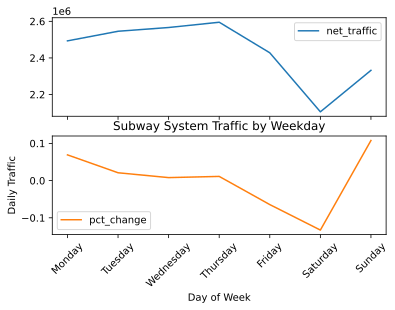

In [27]:
# Plot for net traffic, and percentage change of traffic from Monday-Sunday
daily_df.plot(subplots=True);
plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.xlabel('Day of Week');
plt.ylabel('Daily Traffic');
plt.title('Subway System Traffic by Weekday');

In [28]:
# Daily ridership by station for future use
station_daily = df.groupby(["station", pd.Grouper(key='date_time', freq='D')])[['net_traffic', 'date_time']].sum().sort_values(by=['station']).reset_index()
station_daily

,station,date_time,net_traffic
0,103_ST,2021-12-18,7594.0
1,103_ST,2021-12-19,9775.0
2,103_ST,2021-12-20,7384.0
3,103_ST,2021-12-21,9178.0
4,103_ST,2021-12-22,7911.0
...,...,...,...
3267,ZEREGA_AV,2021-12-23,2559.0
3268,ZEREGA_AV,2021-12-19,1213.0
3269,ZEREGA_AV,2021-12-18,1329.0
3270,ZEREGA_AV,2021-12-20,2476.0


In [29]:
station_daily['pct_change'] = station_daily.groupby(['station'])['net_traffic'].apply(lambda x: x.pct_change())
station_daily['pct_change'] = station_daily['pct_change'].astype(float).map("{:.2%}".format)

In [30]:
# Top stations
top_stations = df.groupby('station')[['net_traffic']].sum().sort_values(by='net_traffic', ascending=False).reset_index()
top_stations['pct_total'] = top_stations['net_traffic'].apply(lambda x: x / top_stations.net_traffic.sum())
top_stations = top_stations.head(20)

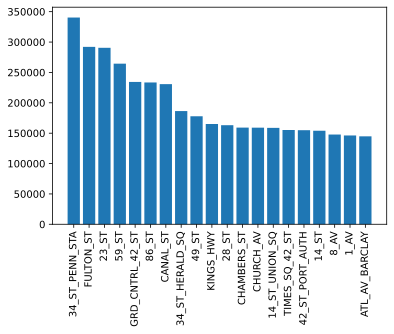

In [31]:
# Plotting traffic for top stations 
plt.bar(top_stations.station, top_stations.net_traffic);
plt.xticks(rotation=90);